In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy 
from tqdm import trange
import cvxpy as cp
from utils import viz_2D, viz_3D, wasserstein_dist, Arrow2D, random_torus_sampler
import warnings
from sklearn.datasets import make_moons 
from scipy.stats import multivariate_normal
sns.set('paper')

(CVXPY) Jan 12 04:55:44 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/Hippolyte/anaconda3/envs/optimaltransport/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <A08A2CF9-B9A1-393C-A32E-68987F02C61E> /Users/Hippolyte/anaconda3/envs/optimaltransport/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so\n  Reason: tried: '/Users/Hippolyte/anaconda3/envs/optimaltransport/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/Hippolyte/anaconda3/envs/optimaltransport/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/Hippolyte/anaconda3/envs/optimaltransport/bin/../lib/liblapack.3.dylib' (no such file), '/Users/Hippolyte/anaconda3/envs/optimaltransport/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld ca

# Sliced Wasserstein code

In [2]:
# Distributions are 1D points (axis=1) but we can have several projected distributions (axis = 0)
def wasserstein_1D(alpha, beta, N_int = 500):
    q = np.linspace(0,1,N_int)
    quant_alpha = np.quantile(alpha, q, axis=1, method='linear').T # shape (N_MC, N_int)
    quant_beta = np.quantile(beta, q,  axis=1, method='linear').T
    return np.sum((quant_alpha - quant_beta)**2, axis = 1)/N_int # shape (N_MC,1)

In [3]:
def sample_on_sphere(npoints, Sdim):
    samples = np.random.randn(Sdim, npoints)
    return samples/np.linalg.norm(samples, axis=0)

In [4]:
def grad_SWF(dim, projected_alpha, projected_beta, thetas):
    (N_dir, n_samples) = projected_alpha.shape
    grad = np.zeros((dim,n_samples))

    for k in range(N_dir):
        ind_sorted_proj_alpha = np.argsort(projected_alpha[k,:])
        ind_sorted_proj_beta = np.argsort(projected_beta[k,:])
        inv_alpha_sort = np.empty(ind_sorted_proj_alpha.shape,dtype=int)
        inv_alpha_sort[ind_sorted_proj_alpha] = np.arange(n_samples)  # inverse of projected_alpha sorting permutation
        OT_permuted_beta_proj_k = projected_beta[k,ind_sorted_proj_beta[inv_alpha_sort]]


        for i in range(n_samples):
            grad[:,i]  += (projected_alpha[k,i] - OT_permuted_beta_proj_k[i]) * thetas[:,k] 
            
    return grad # shape (dim, n_samples)

In [5]:
def SWF(alpha, beta, N_dir = 100, grad = False):
    (dim, n_samples) = alpha.shape
    assert dim > 1, ("The 1-D Wasserstein distance should rather be used")
    thetas = sample_on_sphere(N_dir, dim) # shape (dim, N_DIR)
    
            
    projected_alpha = np.einsum('ij, ik -> kj', alpha, thetas) # shape (N_DIR, n_samples)
    projected_beta = np.einsum('ij, ik -> kj', beta, thetas)

    if not grad:
        return np.sum(wasserstein_1D(projected_alpha, projected_beta))/N_dir
    else:
        return grad_SWF(dim, projected_alpha, projected_beta, thetas)

In [224]:
def move_flow(alpha, target_distrib, n_dir, step, noise = 0):
    alpha_t = alpha.copy()
    (dim, n_samples) = alpha.shape
    grad_swf = SWF(alpha_t,target_distrib, n_dir, grad = True)
    norm_ = np.linalg.norm(grad_swf,axis = 0)
    grad_swf /= (norm_ + 1e-9)
    
    if noise > 0:
        alpha_t -= step *( grad_swf + noise*np.random.randn(dim,n_samples))
    else:
        alpha_t = alpha_t - step * grad_swf  
        
    return alpha_t, grad_swf
        

# Code use

In [7]:
# Generate a cloud of samples from the starting and target distributions
dim = 3
n_samples = 50

alpha = np.random.randn(dim,n_samples)*0.3+4
target = scipy.stats.multivariate_normal(mean=np.ones(dim)*0.5, 
                                         cov = np.eye(dim)*0.1).rvs(size=n_samples).T # shape (dim, n samples)


In [8]:
# Set the parameter of the gradient flow step

N_dir = 1000
step = 0.1
alpha_t, grad_swf = move_flow(alpha, target, N_dir, step)


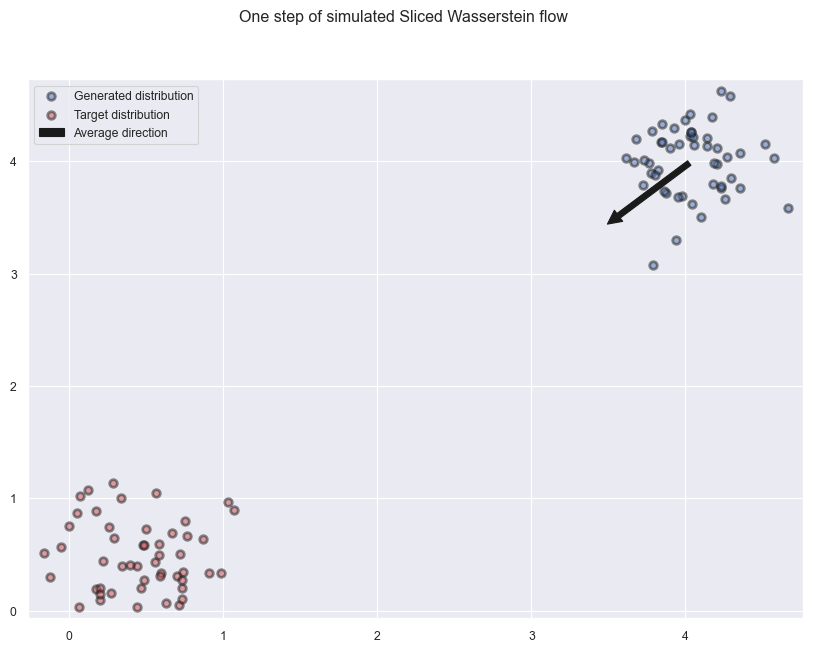

In [9]:
# Visualize the gradient flow step in the 2 first dimensions

viz_2D(alpha, target, arrow_direction = -np.mean(grad_swf,axis=-1), color1 = 'b', color2 = 'r', title = 'One step of simulated Sliced Wasserstein flow')

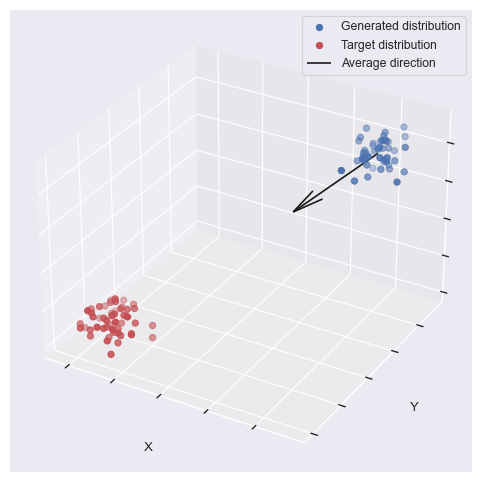

In [10]:
# Visualize the gradient flow step in the 3 first dimensions

viz_3D(alpha, target, color1='b', color2='r',arrow_direction = -np.mean(grad_swf,axis=-1), title = '')

In [11]:
result = wasserstein_dist(alpha_t, target)
warnings.filterwarnings("ignore", category=FutureWarning)
print('The 2-Wasserstein distance between these two cloud of points \n (simulation of continuous distributions) after one step of SWF: ',result)

The 2-Wasserstein distance between these two cloud of points 
 (simulation of continuous distributions) after one step of SWF:  35.642850437713044


/Users/Hippolyte/anaconda3/envs/optimaltransport/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


# Experiments

### Visualize flow converging in 2D 

100%|██████████| 100/100 [00:01<00:00, 74.87it/s]


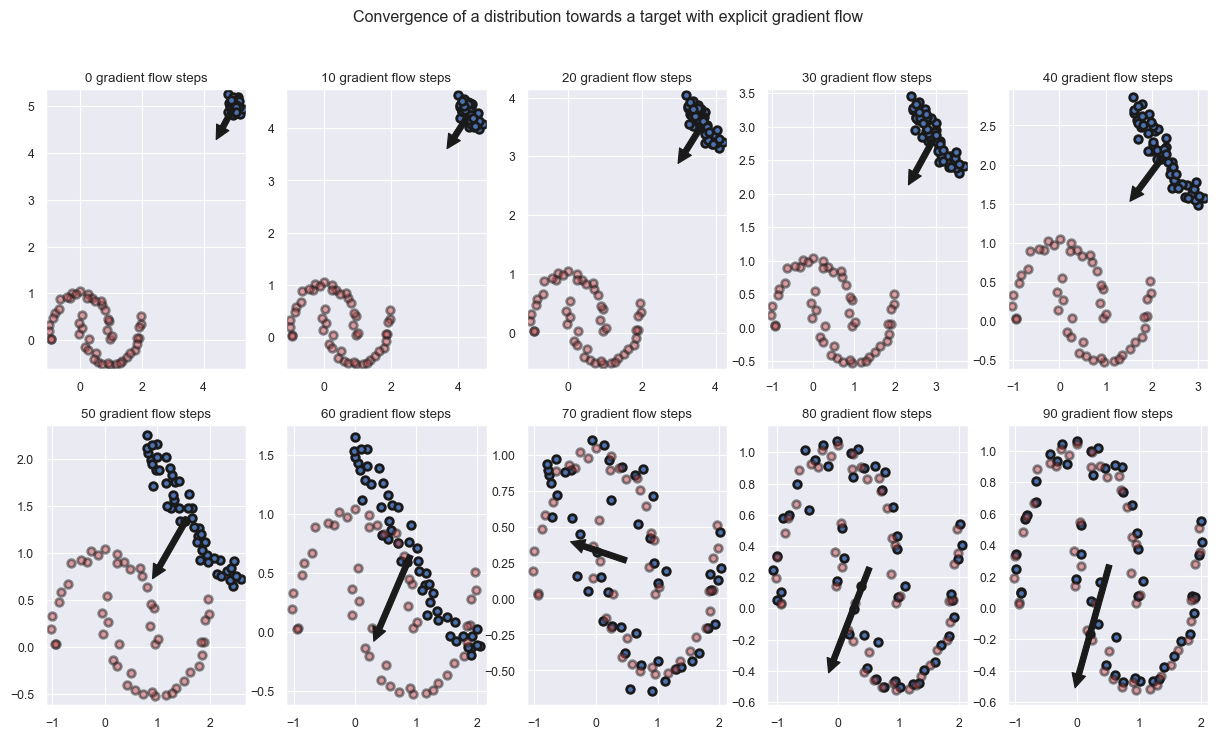

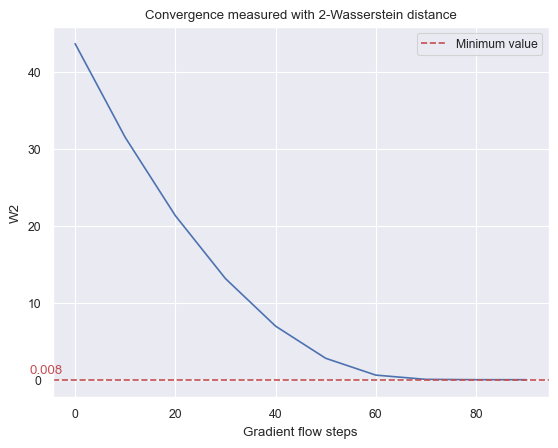

In [205]:
dim = 2
n_samples = 50
N_dir = 100
step_norm = 0.01

l_max = 100
freq_calc = 10
freq_plot = l_max//10


# var = []
# mean = []
wass_loss = []


count = 0

fig, ax = plt.subplots(nrows=2,ncols=5,figsize = (15,8))
starting_alpha = np.random.randn(dim,n_samples)*0.1+5
target = scipy.stats.multivariate_normal(mean=np.ones(dim)*0.5, 
                                        cov = np.eye(dim)*0.3).rvs(size=n_samples).T # shape (dim, n samples)

my_Y, _ = make_moons(n_samples = n_samples, noise = 0.05)
target = my_Y.T
alpha_before_t = (starting_alpha).copy()

for t in trange(l_max):

    alpha_t, grad_swf = move_flow(alpha_before_t, target, N_dir, step)
    
    if t % freq_calc ==0:
        result = wasserstein_dist(alpha_before_t, target)
        wass_loss.append(result)
        # var.append(np.std(alpha_t))
        # mean.append(np.mean(alpha_t))
        
    if  t % freq_plot == 0:
        min_lim_x = np.minimum(np.min(target[0,:]),np.min(alpha_before_t[0,:]))
        max_lim_x = np.maximum(np.max(target[0,:]),np.max(alpha_before_t[0,:]))
        min_lim_y = np.minimum(np.min(target[1,:]),np.min(alpha_before_t[1,:]))
        max_lim_y = np.maximum(np.max(target[1,:]),np.max(alpha_before_t[1,:]))
        ax[count//5][count%5].scatter(alpha_before_t[0,:],alpha_before_t[1,:], s = 30, edgecolors="k", c='b', linewidths=2, label='Generated distribution')
        ax[count//5][count%5].scatter(target[0,:],target[1,:], s = 30, alpha = 0.5, edgecolors="k", c='r', linewidths=2, label='Target distribution')
        arrow_direction = -np.mean(grad_swf,axis=-1)
        starting_arrow = np.mean(alpha_before_t, axis = 1)
        if np.linalg.norm(arrow_direction) > 1e-8:
            arrow_direction /= np.linalg.norm(arrow_direction)
            arrow = Arrow2D(starting_arrow[0], starting_arrow[1], 
                            arrow_direction[0], arrow_direction[1], color='k')
            
            ax[count//5][count%5].add_patch(arrow)
        ax[count//5][count%5].set_xlim(min_lim_x-.1,max_lim_x+.1)
        ax[count//5][count%5].set_ylim(min_lim_y-.1,max_lim_y+.1)
        ax[count//5][count%5].set_title("%i gradient flow steps"%t)
        count +=1
    alpha_before_t = alpha_t

        
plt.suptitle("Convergence of a distribution towards a target with explicit gradient flow")
plt.show()
    
plt.figure()
plt.plot(np.arange(0,l_max,freq_calc),wass_loss)
plt.title("Convergence measured with 2-Wasserstein distance")
plt.xlabel('Gradient flow steps')
plt.axhline(y=np.min(wass_loss), color='r', linestyle='--', label = 'Minimum value')
plt.ylabel('W2')
plt.annotate(np.round(np.min(wass_loss),3),
             xy=(0, np.min(wass_loss)), xycoords='data',
             xytext=(-33, 5), textcoords='offset points',
             color = 'r'
            )
plt.legend()
plt.show()



In [ ]:
# Plot statistics of the distributions (variance and mean)

# plt.figure()
# plt.plot(np.arange(0,l_max,freq_calc),var)
# plt.title("Evolution of the variance of the empirical distribution")
# plt.xlabel('Gradient flow steps')
# plt.axhline(y=np.std(target), color='r', linestyle='--', label = 'Variance of the target')
# plt.ylabel('Standard Deviation')
# plt.legend()
# plt.show()



# plt.figure()
# plt.plot(np.arange(0,l_max,freq_calc),mean)
# plt.title("Evolution of the mean of the empirical distribution")
# plt.xlabel('Gradient flow steps')
# plt.axhline(y=np.std(target), color='r', linestyle='--', label = 'Mean of the target')
# plt.ylabel('Mean')
# plt.legend()
# plt.show()

### Visualize flow converging in 3D 

  0%|          | 0/200 [00:00<?, ?it/s]

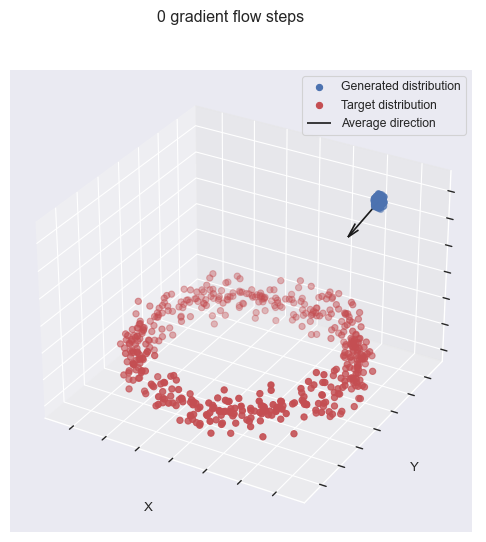

 10%|█         | 20/200 [00:10<01:31,  1.97it/s]

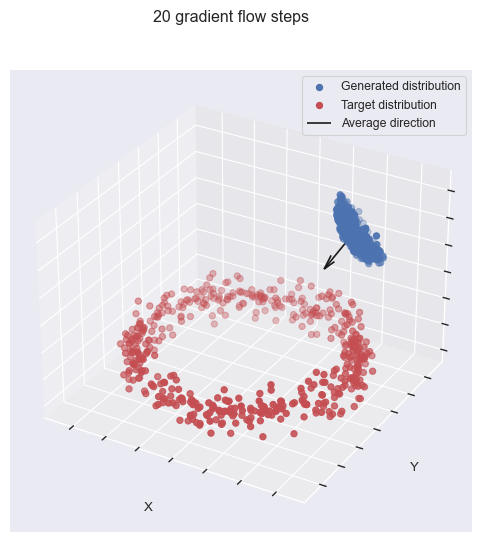

 20%|██        | 40/200 [00:20<01:20,  1.98it/s]

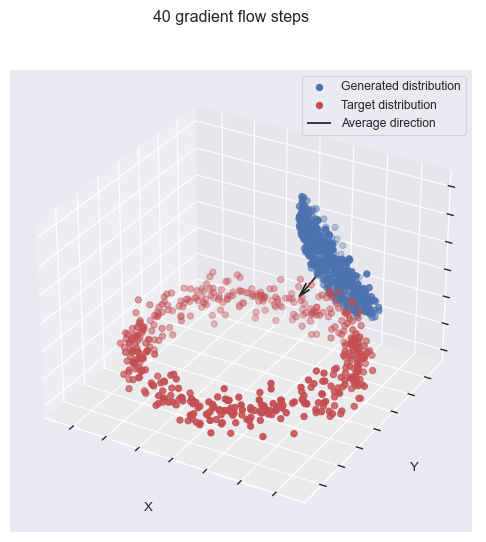

 30%|███       | 60/200 [00:30<01:10,  1.99it/s]

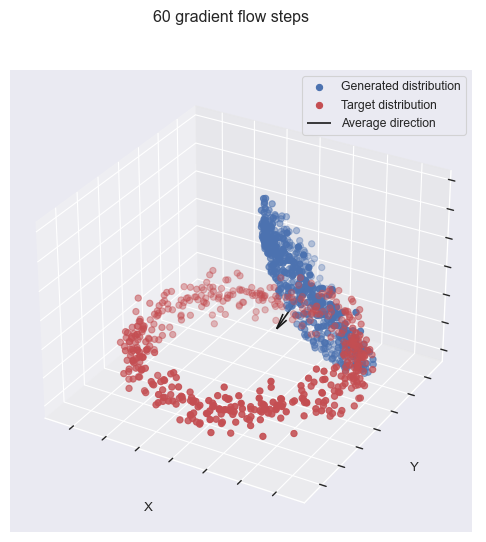

 40%|████      | 80/200 [00:41<01:01,  1.94it/s]

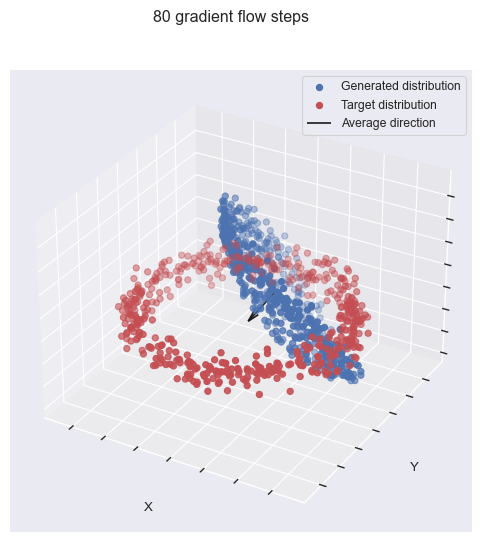

 50%|█████     | 100/200 [00:51<00:50,  1.97it/s]

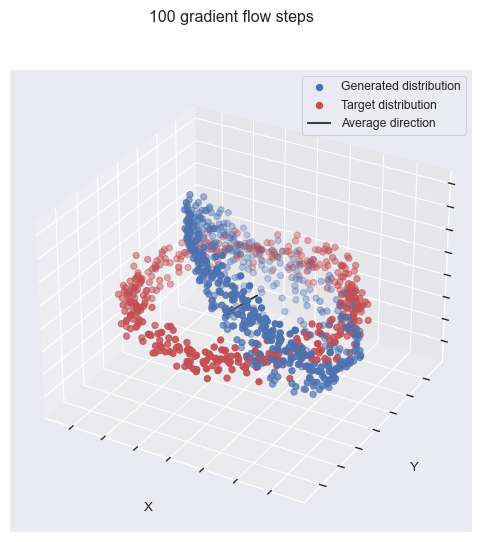

 60%|██████    | 120/200 [01:01<00:40,  1.98it/s]

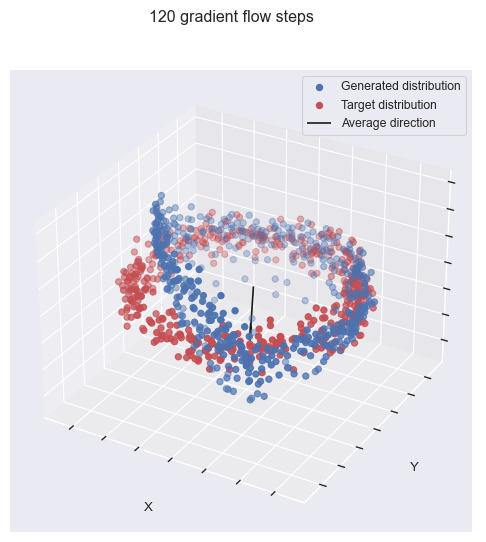

 70%|███████   | 140/200 [01:11<00:30,  1.98it/s]

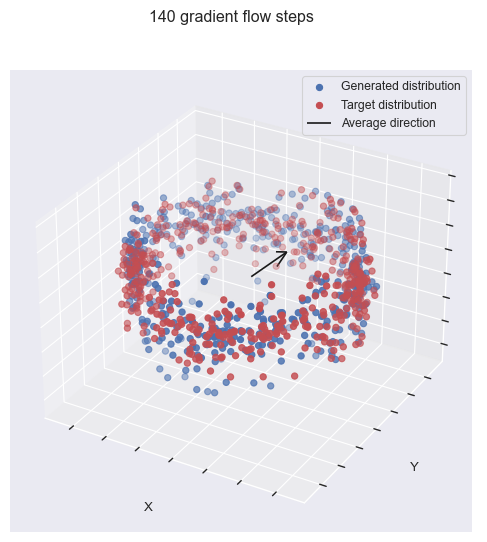

 80%|████████  | 160/200 [01:22<00:20,  1.94it/s]

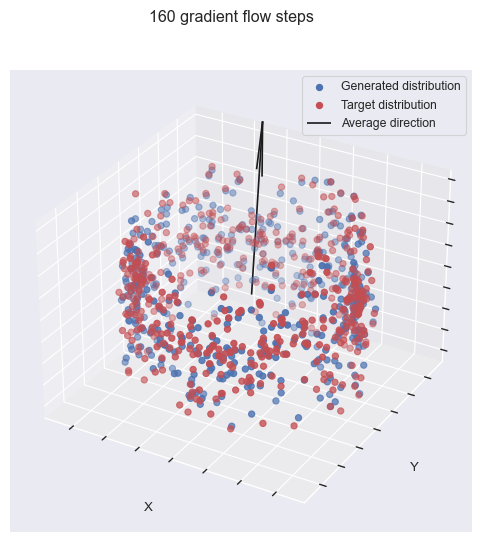

 90%|█████████ | 180/200 [01:32<00:10,  1.98it/s]

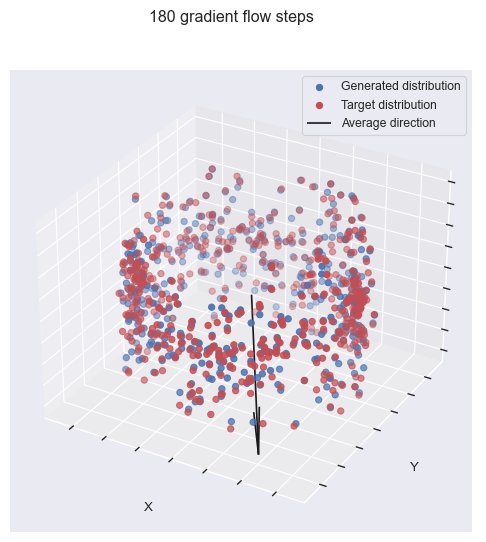

100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


In [221]:
dim = 3
n_samples = 500
N_dir = 500
step_norm = 1

starting_alpha = np.random.randn(dim,n_samples)*0.1+5
target = scipy.stats.multivariate_normal(mean=np.ones(dim)*0.5, 
                                         cov = np.eye(dim)*0.3).rvs(size=n_samples).T # shape (dim, n samples)
alpha_before_t = starting_alpha.copy()
target  = random_torus_sampler(1, 6, n_samples)

l_max = 200
freq_calc = 20
freq_plot = l_max//10

wass_loss = []

for t in trange(l_max):
    alpha_t, grad_swf = move_flow(alpha_before_t, target, N_dir, step)
    if t % freq_plot == 0:
        
        viz_3D(alpha_before_t,target, arrow_direction = -np.mean(grad_swf,axis=-1), title='%i gradient flow steps'%t)
        
    # if t % freq_calc == 0:

        # result = wasserstein_dist(alpha_before_t, target)
        # wass_loss.append(result)

    alpha_before_t = alpha_t

# plt.figure()
# plt.plot(np.arange(0,l_max,freq_calc),wass_loss)
# plt.title("Convergence measured with 2-Wasserstein distance")
# plt.xlabel('Gradient flow steps')
# plt.axhline(y=np.min(wass_loss), color='r', linestyle='--', label = 'Minimum value')
# plt.ylabel('W2')
# plt.annotate(np.round(np.min(wass_loss),1),
#              xy=(0, np.min(wass_loss)), xycoords='data',
#              xytext=(-33, 5), textcoords='offset points',
#              color = 'r'
#             )
# plt.legend()
# plt.show()

### Check the influence of the number of directions

In [182]:
dim = 3
n_samples = 500
step_norm = 1



Sigma = np.random.rand(dim,dim) 
Sigma = Sigma @ Sigma.T
mu = np.random.rand(dim)*2+[3,0,0]
target = scipy.stats.multivariate_normal(mean=mu, 
                                        cov = Sigma.T).rvs(size=n_samples).T # shape (dim, n samples)

starting_alpha = (np.random.rand(dim,n_samples)+ 3)*2


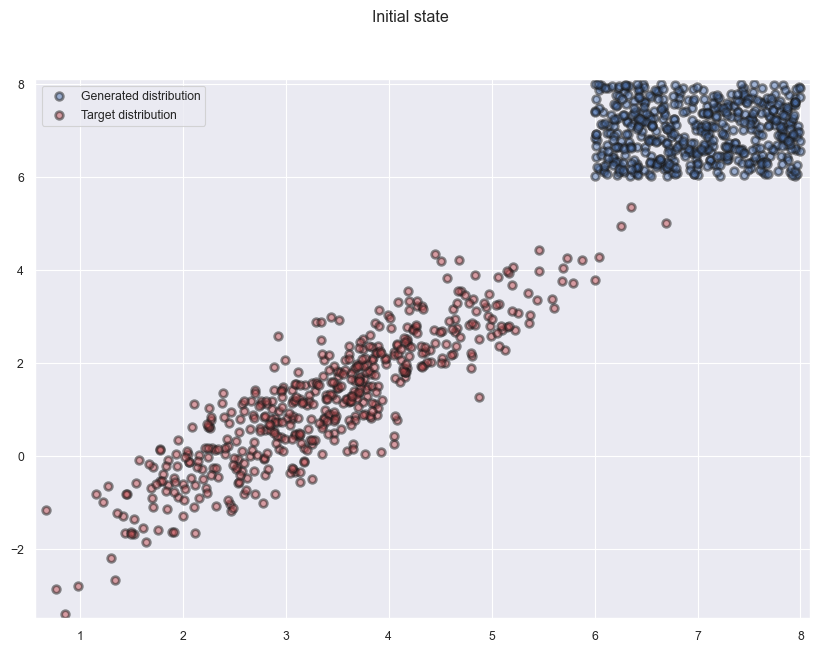

In [183]:

alpha_before_t = (starting_alpha).copy()
viz_2D(alpha_before_t,target, title='Initial state')

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [11:08<00:00, 14.95it/s]


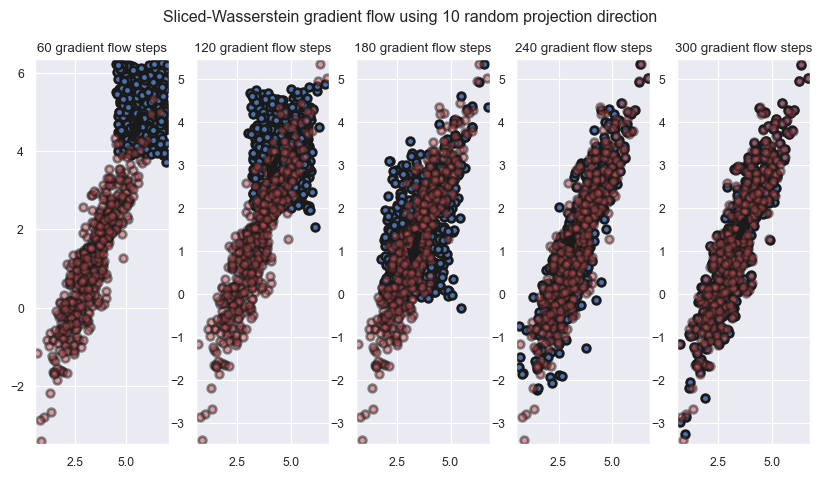

In [196]:
l_max = 10000
freq_calc = 100
freq_plot = 60
step = 0.1

count = 0
number_directions = [10]
wass_loss = {k:[] for k in number_directions} 


for N_dir in number_directions:
    fig, ax = plt.subplots(nrows=1,ncols=5,figsize = (10,5))
    alpha_before_t = (starting_alpha).copy()
    for t in trange(l_max):

        alpha_t, grad_swf = move_flow(alpha_before_t, target, N_dir, step)
        
        if t % freq_calc ==0:
            result = wasserstein_dist(alpha_before_t, target)
            wass_loss[N_dir].append(result)

        if t % 1000 == 0:
            step *= 0.5
        if  t>0 and t<301 and t % freq_plot == 0 :
            min_lim_x = np.minimum(np.min(target[0,:]),np.min(alpha_before_t[0,:]))
            max_lim_x = np.maximum(np.max(target[0,:]),np.max(alpha_before_t[0,:]))
            min_lim_y = np.minimum(np.min(target[1,:]),np.min(alpha_before_t[1,:]))
            max_lim_y = np.maximum(np.max(target[1,:]),np.max(alpha_before_t[1,:]))
            ax[count%5].scatter(alpha_before_t[0,:],alpha_before_t[1,:], s = 30, edgecolors="k", c='b', linewidths=2, label='Generated distribution')
            ax[count%5].scatter(target[0,:],target[1,:], s = 30, alpha = 0.5, edgecolors="k", c='r', linewidths=2, label='Target distribution')
            arrow_direction = -np.mean(grad_swf,axis=-1)
            starting_arrow = np.mean(alpha_before_t, axis = 1)
            if np.linalg.norm(arrow_direction) > 1e-8:
                arrow_direction /= np.linalg.norm(arrow_direction)
                arrow = Arrow2D(starting_arrow[0], starting_arrow[1], 
                                arrow_direction[0], arrow_direction[1], color='k')
                
                ax[count%5].add_patch(arrow)
            ax[count%5].set_xlim(min_lim_x-.1,max_lim_x+.1)
            ax[count%5].set_ylim(min_lim_y-.1,max_lim_y+.1)
            ax[count%5].set_title("%i gradient flow steps"%t)
            count +=1
        alpha_before_t = alpha_t

        
    plt.suptitle("Sliced-Wasserstein gradient flow using %i random projection direction"%N_dir)
    plt.show()
    


In [197]:
for N_dir in number_directions:
    print("Number of direction %i, minimum obtained:"%N_dir,np.min(wass_loss[N_dir]))

Number of direction 10, minimum obtained: 7.116797151016035e-10


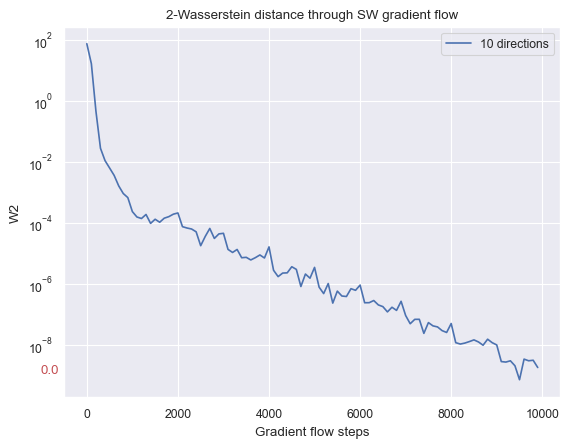

In [198]:
plt.figure()
for N_dir in number_directions:
    plt.plot(np.arange(0,l_max,freq_calc),wass_loss[N_dir],label='%i directions'%N_dir)
    plt.annotate(np.round(np.min(wass_loss[N_dir]),5),
             xy=(0, np.min(wass_loss[N_dir])), xycoords='data',
             xytext=(-33, 5), textcoords='offset points',
             color = 'r'
            )
plt.title("2-Wasserstein distance through SW gradient flow")
plt.xlabel('Gradient flow steps')
# plt.axhline(y=np.min(wass_loss), color='r', linestyle='--', label = 'Minimum value')
plt.ylabel('W2')
plt.semilogy()

plt.legend()
plt.show()

### Bimodal distributions

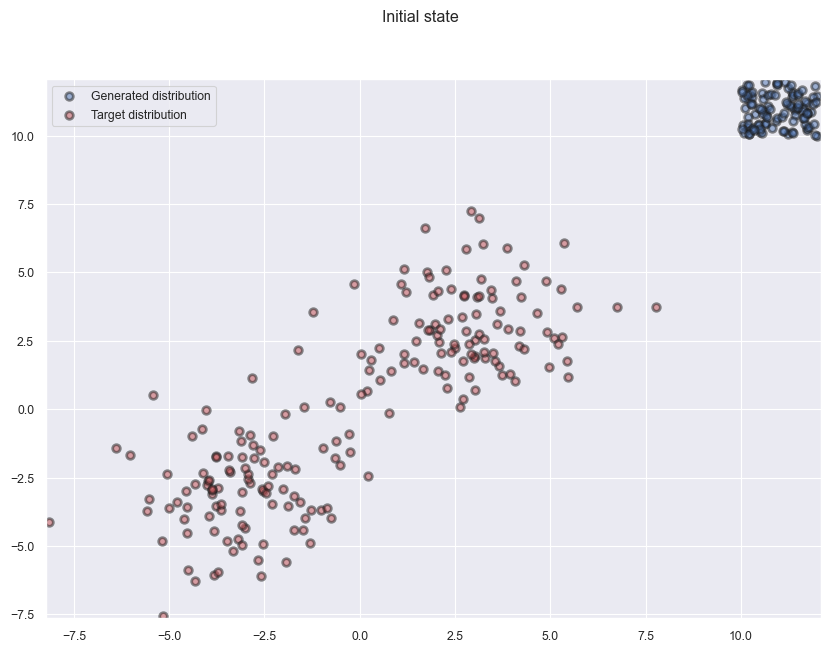

In [201]:
# Parameters 
dim = 2 # dimension of the samples
n_samples = 100 # number of samples
m = 2  # number of Gaussians in the GMM
inv_proximity = 3
mu = np.array([[-1,-1],[1,1]])*inv_proximity # mean of the Gaussians,

# Sample a set of observations


Sigma = np.random.rand(dim,dim) 
Sigma = (Sigma * Sigma.T + 2*np.eye(dim,dim))
# definite positive matrices defining the covariance martrices of the Gaussians

target = np.hstack([scipy.stats.multivariate_normal(mean=mu[0], 
                                        cov = Sigma.T).rvs(size=n_samples).T,scipy.stats.multivariate_normal(mean=mu[1], 
                                        cov = Sigma.T).rvs(size=n_samples).T])

starting_alpha = (np.random.rand(dim,n_samples)+ 5)*2
alpha_before_t = (starting_alpha).copy()
viz_2D(alpha_before_t,target, title='Initial state')

In [208]:
l_max = 5000
freq_calc = 100
noise = 0
N_dir = 500
wass_loss = []
step = 0.1

alpha_before_t = (starting_alpha).copy()
for t in trange(l_max):

    alpha_t, grad_swf = move_flow(alpha_before_t, target, N_dir, step)
    
    if t % freq_calc ==0:
        result = wasserstein_dist(alpha_before_t, target)
        wass_loss.append(result)
    if t%500 == 0:
        step *= 0.8
    alpha_before_t = alpha_t



100%|██████████| 5000/5000 [09:23<00:00,  8.88it/s]


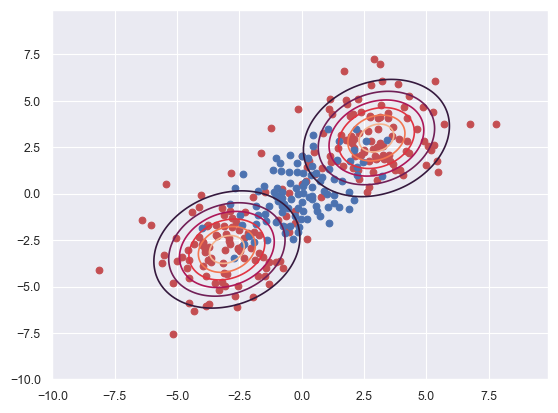

In [211]:
plt.figure()
plt.scatter(target[0,:],target[1,:],color = 'r',label='Target distribution')
plt.scatter(alpha_before_t[0,:],alpha_before_t[1,:],color = 'b',label='Generated distribution')
x, y = np.mgrid[-10:10:.1, -10:10:.1]
data = np.dstack((x, y))
for i in range(2):
    rv = scipy.stats.multivariate_normal(mu[i], Sigma)
    z = rv.pdf(data)
    plt.contour(x, y, z)
# plt.title("Noisy gradient flow")
plt.show()

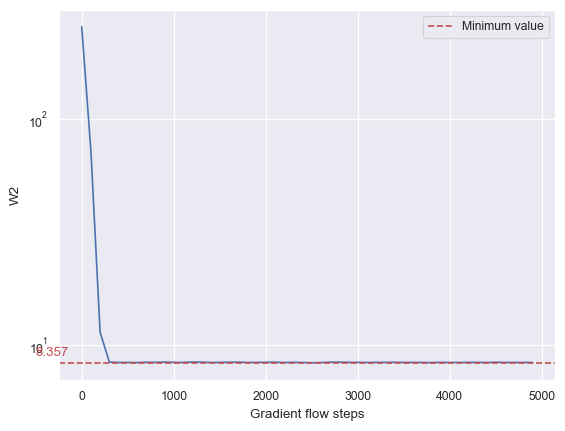

In [212]:
plt.figure()
plt.plot(np.arange(0,l_max,freq_calc),wass_loss)
# plt.title("Convergence measured with 2-Wasserstein distance with %1.2f noise"%noise)
plt.xlabel('Gradient flow steps')
plt.axhline(y=np.min(wass_loss), color='r', linestyle='--', label = 'Minimum value')
plt.ylabel('W2')
plt.semilogy()
plt.annotate(np.round(np.min(wass_loss),3),
             xy=(0, np.min(wass_loss)), xycoords='data',
             xytext=(-33, 5), textcoords='offset points',
             color = 'r'
            )
plt.legend()
plt.show()

### Noisy gradient flow 

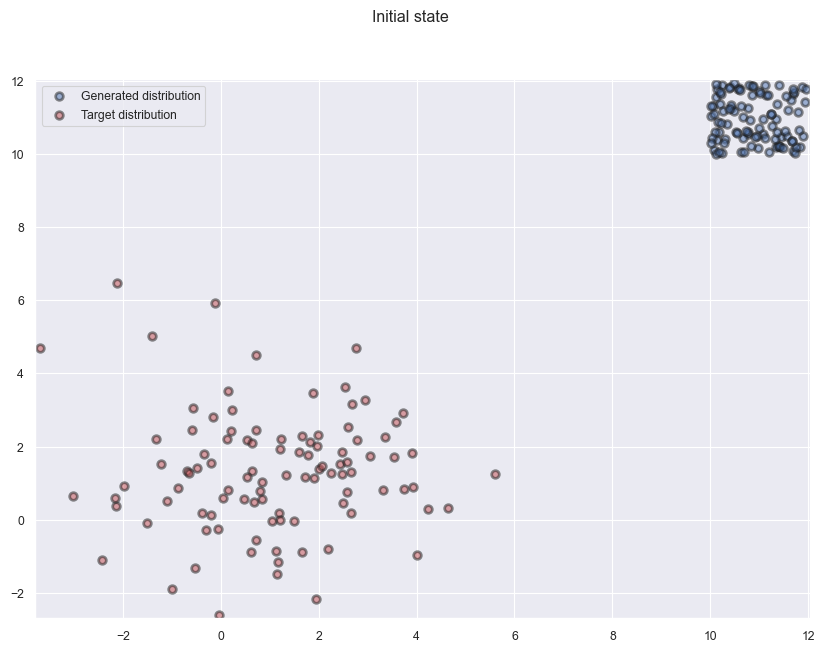

In [213]:
# Parameters 
dim = 2 # dimension of the samples
n_samples = 100 # number of samples


mu = np.array([1,1])

# Sample a set of observations


Sigma = np.random.rand(dim,dim) 
Sigma = (Sigma * Sigma.T + 2*np.eye(dim,dim))
# definite positive matrices defining the covariance martrices of the Gaussians

target = scipy.stats.multivariate_normal(mean=mu, 
                                        cov = Sigma.T).rvs(size=n_samples).T

starting_alpha = (np.random.rand(dim,n_samples)+ 5)*2
alpha_before_t = (starting_alpha).copy()
viz_2D(alpha_before_t,target, title='Initial state')

In [243]:
l_max = 2000
freq_calc = 20
noise = 10
N_dir = 100
wass_loss = []
wass_loss_noise = []
step = 0.1
alpha_before_t = (starting_alpha).copy()
alpha_before_t_noisy = (starting_alpha).copy()

for t in trange(l_max):

    alpha_t_noisy, grad_swf = move_flow(alpha_before_t_noisy, target, N_dir, step, noise = noise)
    alpha_t, grad_swf = move_flow(alpha_before_t, target, N_dir, step, noise = 0)
    
    if t % freq_calc ==0:
        result = wasserstein_dist(alpha_before_t_noisy, target)
        wass_loss_noise.append(result)
        
        result = wasserstein_dist(alpha_before_t, target)
        wass_loss.append(result)
        
    if t%500 ==0:
        step *= 0.5

    alpha_before_t = alpha_t
    alpha_before_t_noisy = alpha_t_noisy



100%|██████████| 2000/2000 [01:42<00:00, 19.45it/s]


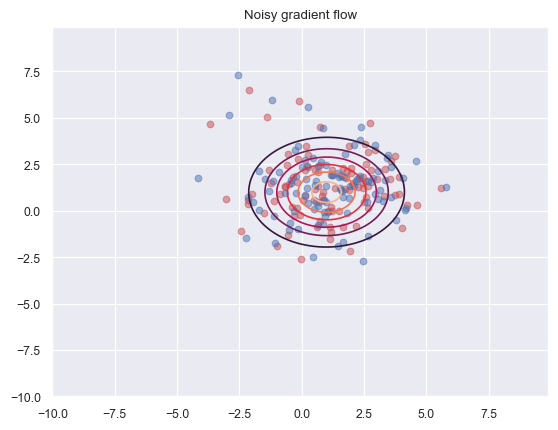

In [244]:
plt.figure()
plt.scatter(target[0,:],target[1,:],color = 'r',label='Target distribution',alpha=0.5)
plt.scatter(alpha_before_t_noisy[0,:],alpha_before_t_noisy[1,:],color = 'b',label='Generated distribution',alpha=0.5)
x, y = np.mgrid[-10:10:.1, -10:10:.1]
data = np.dstack((x, y))
rv = scipy.stats.multivariate_normal(mu, Sigma)
z = rv.pdf(data)
plt.contour(x, y, z)
plt.title("Noisy gradient flow")
plt.show()

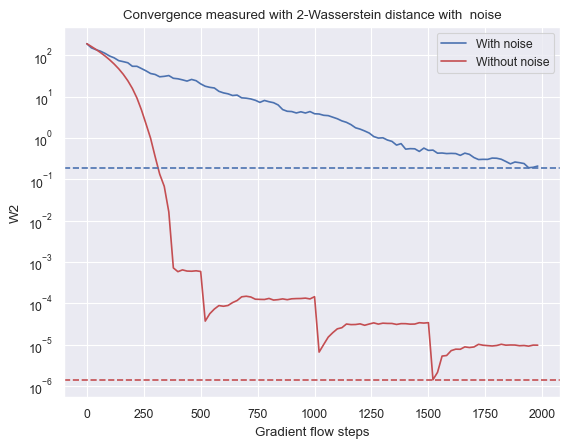

In [246]:
plt.figure()
plt.plot(np.arange(0,l_max,freq_calc),wass_loss_noise,color = 'b', label='With noise')
plt.plot(np.arange(0,l_max,freq_calc),wass_loss,color = 'r', label='Without noise')
plt.title("Convergence measured with 2-Wasserstein distance with  noise")
plt.xlabel('Gradient flow steps')
plt.axhline(y=np.min(wass_loss_noise), color='b', linestyle='--')
plt.axhline(y=np.min(wass_loss), color='r', linestyle='--')
plt.ylabel('W2')
plt.semilogy()
# plt.annotate(np.round(np.min(wass_loss),3),
#              xy=(0, np.min(wass_loss)), xycoords='data',
#              xytext=(-33, 5), textcoords='offset points',
#              color = 'r'
#             )
plt.legend()
plt.show()